In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
from pulp import LpVariable
from sklearn.linear_model import LinearRegression
import seaborn as sns

sns.set()

In [2]:
demand=pd.read_csv('demands.csv')
centers=pd.read_csv('centers.csv')
distances=pd.read_csv('distances.csv')

# predicting demand using LR

In [3]:
regionDemand=demand.groupby(['Region','Year'])['Demand'].sum()

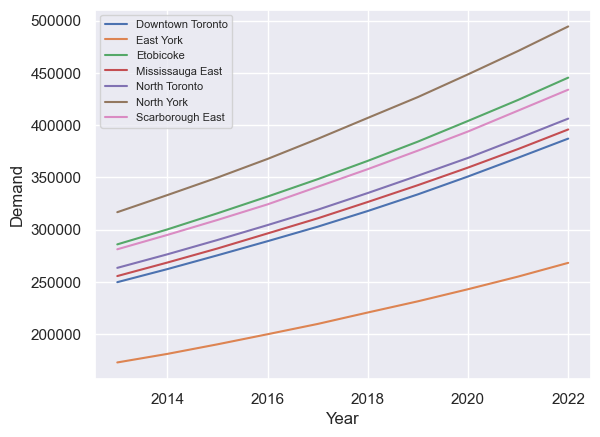

In [4]:
for region in demand['Region'].unique():
    plt.plot(regionDemand[region].index, regionDemand[region].values, label=region)
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend(fontsize=8)
plt.show()

In [5]:
# Group the data by region
grouped = demand.groupby('Region')

# Loop over the regions and make predictions for each one
predictions = []
for area, group in grouped:
    # Split the data into features (year) and target variable (population)
    X = group['Year'].values.reshape(-1, 1)
    y = group['Demand'].values

    # Create a new linear regression model and fit it to the data
    model = LinearRegression()
    model.fit(X, y)

    # Predict the population for the years 2023, 2024, and 2025
    X_pred = np.array([2023, 2024, 2025]).reshape(-1, 1)
    y_pred = model.predict(X_pred)

    # Create a new DataFrame to store the predictions
    pred_df = pd.DataFrame({
        'Year': [2023, 2024, 2025],
        'Demand': y_pred,
        'Region': area
    })

    predictions.append(pred_df)

# Concatenate the predictions for all regions into a single DataFrame
pred_demand = pd.concat(predictions)

pred_demand['Demand'] = pred_demand['Demand'].astype(int)

# Location Model with only considering Year 2023

In [6]:
#centers
center=centers['Center'].tolist()
num_center=len(center)

#demand zones
zone=demand['Region'].unique().tolist()
num_zone=len(zone)

In [7]:
### demand in each zone
zonedemand = {}
for j in zone:
    zonedemand[j] = float(pred_demand[(pred_demand['Region']==j) & (pred_demand['Year']==2023)]['Demand'])

### center capacities (dictionary)
centercapacity = {}
for i in center:
    centercapacity[i] = int(centers[centers['Center']==i]['Maximum capacity'])

### center operating costs (dictionary)
centercost = {}
for i in center:
    centercost[i] = float(centers[centers['Center']==i]['Operating Costs']+centers[centers['Center']==i]['Opening Costs'])
    
### Center-zone travel costs (dictionary)
centerzonecost = {}
for i in center:
    for j in zone:
        centerzonecost[(i,j)] = float((distances[(distances["Center"] == i)&(distances["Region"] == j)]["Distance"]*0.25))

### Center-Zone rev         
centerzonerev = {}
for i in center:
    for j in zone:
        centerzonerev[(i,j)] = 42
        
### Salary
salary = {}
for i in center:
    for j in zone:
        salary[(i,j)] = 37.85

### PH limitation
PH = {}
for i in center:
    PH[i]= int(centers[centers['Center']==i]['Num MPs'])

In [8]:
# Variables: if a center is opened/allocated
yvar = pulp.LpVariable.dict("y", center, cat=pulp.LpBinary)

# Variables: amount of HPs from each zone allocated to center
xvar = pulp.LpVariable.dict("x", (center, zone), lowBound=0.0, cat=pulp.LpContinuous)

In [9]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

In [10]:
# Constraint: satisfies zone j's demand
for j in zone:
    locationModel += pulp.lpSum( [xvar[(i,j)] for i in center] ) <= zonedemand[j]

# Constraint: satisfies center i's capacity
for i in center:        
    locationModel += pulp.lpSum( [xvar[(i,j)] for j in zone] ) <= centercapacity[i] * yvar[i]
    
# Constraint: maximum hours
for i in center:
    locationModel += pulp.lpSum( [xvar[(i,j)] for j in zone]) <= PH[i]*6*250

In [11]:
# Objective function

# --- rev from gron
obj = pulp.lpSum([centerzonerev[i,j] * xvar[(i,j)] for i in center for j in zone])

# --- operating cost
obj -= pulp.lpSum([centercost[i] * yvar[i] for i in center])

# --- travel costs
obj -= pulp.lpSum([centerzonecost[(i,j)] * xvar[(i,j)] for i in center for j in zone ] )

# --- salary
obj -= pulp.lpSum([salary[(i,j)]*xvar[(i,j)] for i in center for j in zone])

# add objective to model
locationModel += obj

In [12]:
# Write LP to file (optional, but often good to inspect model and find errors)
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [13]:
# Total cost
totalProfit = pulp.value(locationModel.objective)
print("Profit: " + str(totalProfit))

Profit: 2028499.999999999


In [14]:
# Print solution (you can add to the dataframe if needed)
Revenue_location=0
for i in center:
    if yvar[i].varValue >= 1.0:
        print("Center " + str(i) + " is opened")                            
        for j in zone:
            if xvar[(i,j)].varValue > 0.0:
                print("\t\tServes zone " + str(j) + " - with capacity " + str(xvar[(i,j)].varValue))
                Revenue_location+=xvar[(i,j)].varValue*42

Center Center A is opened
		Serves zone North York - with capacity 322500.0
Center Center B is opened
		Serves zone Scarborough East - with capacity 187500.0
Center Center D is opened
		Serves zone Mississauga East - with capacity 180000.0


In [15]:
print("Total Revenue is "+str(Revenue_location)+', and '+"Total Cost is "+str(Revenue_location-totalProfit))

Total Revenue is 28980000.0, and Total Cost is 26951500.0


# Location Model with multi-period

In [16]:
### demand in each zone
zone_period_demand = {}

for j in zone:
    zone_period_demand[j] = {}
    for period in [2023, 2024, 2025]:
        d = float(pred_demand[(pred_demand['Region']==j) & (pred_demand['Year']==period)]['Demand'])
        zone_period_demand[j][period] = d

In [17]:
### center capacity
center_period_capacity = {}

for i in center:
    center_period_capacity[i] = {}
    for period in [2023, 2024, 2025]:
        capacity = int(centers[(centers['Center']==i)]['Maximum capacity'])
        center_period_capacity[i][period] = capacity

In [18]:
### center operating costs (dictionary)???
center_period_cost = {}

for i in center:
    center_period_cost[i] = {}
    for period in [2023, 2024, 2025]:
        if period==2023:
            ccost = float(centers[centers['Center']==i]['Operating Costs']+centers[centers['Center']==i]['Opening Costs'])
        else:
            ccost = float(centers[centers['Center']==i]['Operating Costs'])
        center_period_cost[i][period]=ccost

In [19]:
### Center-zone travel costs (dictionary)
center_period_zonecost = {}

for i in center:
    for j in zone:
        center_period_zonecost[i,j] = {}
        for k in [2023, 2024, 2025]:
            czcost= float((distances[(distances["Center"] == i)&(distances["Region"] == j)]["Distance"]*0.25))
            center_period_zonecost[i,j][k] = czcost

In [20]:
### Center-Zone rev         
center_period_zonerev = {}

for i in center:
    for j in zone:
        center_period_zonerev[i,j] = {}
        for k in [2023, 2024, 2025]:
            czrev = 42
            center_period_zonerev[i,j][k]=czrev

In [21]:
### PH limitation
PH_period = {}

for i in center:
    PH_period[i] = {}
    for period in [2023, 2024, 2025]:
        PH = int(centers[centers['Center']==i]['Num MPs'])
        PH_period[i][period]=PH

In [22]:
### Salary
salary_period = {}

for i in center:
    for j in zone:
        salary= 37.85
        salary_period[i,j] = {}
        for k in [2023, 2024, 2025]:
            salary_period[i,j][k]=salary
            salary=salary*1.025

In [23]:
# Variables: if a center is opened/allocated
yvar_m = pulp.LpVariable.dict("y", (center, [2023,2024,2025]), cat=pulp.LpBinary)

# Variables: amount of HPs from each zone allocated to center
xvar_m = pulp.LpVariable.dict("x", (center, zone, [2023,2024,2025]), lowBound=0.0, cat=pulp.LpContinuous)

In [24]:
# Initialize model and objective sense
Model_M = pulp.LpProblem(name="ModelM", sense=pulp.LpMaximize)

In [25]:
# Constraint: satisfies zone j's demand
for j in zone:
    for k in [2023, 2024, 2025]:
        Model_M += pulp.lpSum( [xvar_m[(i,j,k)] for i in center] ) <= zone_period_demand[j][k]

# Constraint: satisfies center i's capacity
for i in center:
    for k in [2023, 2024, 2025]:
        Model_M += pulp.lpSum( [xvar_m[(i,j,k)] for j in zone] ) <= center_period_capacity[i][k] * yvar_m[i,k]
    
# Constraint: maximum hours
for i in center:
    for k in [2023, 2024, 2025]:
        Model_M += pulp.lpSum( [xvar_m[(i,j,k)] for j in zone]) <= PH_period[i][k]*6*250

In [26]:
# Objective function

# --- rev from gron
obj_M = pulp.lpSum([center_period_zonerev[i,j][k] * xvar_m[(i,j,k)] for i in center for j in zone for k in [2023, 2024, 2025]])

# --- operating cost
obj_M -= pulp.lpSum([center_period_cost[i][k] * yvar_m[i,k] for i in center for k in [2023, 2024, 2025]])

# --- travel costs
obj_M -= pulp.lpSum([center_period_zonecost[i,j][k] * xvar_m[(i,j,k)] for i in center for j in zone ] for k in [2023, 2024, 2025])

# --- salary
obj_M -= pulp.lpSum([salary_period[i,j][k]*xvar_m[(i,j,k)] for i in center for j in zone for k in [2023, 2024, 2025]])

# add objective to model
Model_M += obj_M

In [27]:
# Write LP to file (optional, but often good to inspect model and find errors)
Model_M.writeLP("Model_M.lp")

# Solve model
Model_M.solve()
print("Status:", pulp.LpStatus[Model_M.status])

Status: Optimal


In [28]:
# Total cost
Profit_M = pulp.value(Model_M.objective)
print("Profit_M: " + str(Profit_M))

Profit_M: 4110439.687500003


In [29]:
# Print solution (you can add to the dataframe if needed)
for i in center:
    for k in [2023,2024,2025]:
        if yvar_m[i,k].varValue >= 1.0:
            print("Center " + str(i) + " is opened in "+str(k))                            
            for j in zone:
                if xvar_m[(i,j,k)].varValue > 0.0:
                    print("\t\tServes zone " + str(j) + " - with capacity " + str(xvar_m[(i,j,k)].varValue))

Center Center A is opened in 2023
		Serves zone North York - with capacity 322500.0
Center Center A is opened in 2024
		Serves zone North York - with capacity 322500.0
Center Center A is opened in 2025
		Serves zone North York - with capacity 322500.0
Center Center B is opened in 2023
		Serves zone Scarborough East - with capacity 187500.0
Center Center B is opened in 2024
		Serves zone Scarborough East - with capacity 187500.0
Center Center B is opened in 2025
		Serves zone Scarborough East - with capacity 187500.0
Center Center D is opened in 2023
		Serves zone Mississauga East - with capacity 180000.0
Center Center D is opened in 2024
		Serves zone Mississauga East - with capacity 180000.0
Center Center D is opened in 2025
		Serves zone Mississauga East - with capacity 180000.0


# Model with considering multi-period + hiringof workers

In [30]:
### demand in each zone
zone_period_demand = {}

for j in zone:
    zone_period_demand[j] = {}
    for period in [2023, 2024, 2025]:
        d = float(pred_demand[(pred_demand['Region']==j) & (pred_demand['Year']==period)]['Demand'])
        zone_period_demand[j][period] = d

In [31]:
### center capacity
center_period_capacity = {}

for i in center:
    center_period_capacity[i] = {}
    for period in [2023, 2024, 2025]:
        capacity = int(centers[(centers['Center']==i)]['Maximum capacity'])
        center_period_capacity[i][period] = capacity

In [32]:
### center operating costs (dictionary)
center_period_cost = {}

for i in center:
    center_period_cost[i] = {}
    for period in [2023, 2024, 2025]:
        if period==2023:
            ccost = float(centers[centers['Center']==i]['Operating Costs']+centers[centers['Center']==i]['Opening Costs'])
        else:
            ccost = float(centers[centers['Center']==i]['Operating Costs'])
        center_period_cost[i][period]=ccost

In [33]:
### Center-zone travel costs (dictionary)
center_period_zonecost = {}

for i in center:
    for j in zone:
        center_period_zonecost[i,j] = {}
        for k in [2023, 2024, 2025]:
            czcost= float((distances[(distances["Center"] == i)&(distances["Region"] == j)]["Distance"]*0.25))
            center_period_zonecost[i,j][k] = czcost

In [34]:
### Center-Zone rev         
center_period_zonerev = {}

for i in center:
    for j in zone:
        center_period_zonerev[i,j] = {}
        for k in [2023, 2024, 2025]:
            czrev = 42
            center_period_zonerev[i,j][k]=czrev

In [35]:
### PH limitation
PH_period = {}

for i in center:
    PH_period[i] = {}
    for period in [2023, 2024, 2025]:
        PH = int(centers[centers['Center']==i]['Num MPs'])
        PH_period[i][period]=PH

In [36]:
### Salary
salary_period = {}

for i in center:
    for j in zone:
        salary= 37.85
        salary_period[i,j] = {}
        for k in [2023, 2024, 2025]:
            salary_period[i,j][k]=salary
            salary=salary*1.025

In [37]:
# Variables: if a center is opened/allocated
yvar_f = pulp.LpVariable.dict("y", (center, [2023,2024,2025]), cat=pulp.LpBinary)

# Variables: amount of HPs from each zone allocated to center
xvar_f = pulp.LpVariable.dict("x", (center, zone, [2023,2024,2025]), lowBound=0.0, cat=pulp.LpContinuous)

# **** Worker flow ****
wvar_f = pulp.LpVariable.dict("w", (center, [2023,2024,2025]), lowBound=0.0, cat=pulp.LpInteger)

# **** New hires ****
hvar_f = pulp.LpVariable.dict("h", (center,[2023,2024,2025]), lowBound=0.0, cat=pulp.LpInteger)

In [38]:
# Initialize model and objective sense
Model_F = pulp.LpProblem(name="Model_F", sense=pulp.LpMaximize)

In [39]:
# Constraint: satisfies worker capacity
for i in center:
    for k in [2023,2024,2025]:
        numHPs = (wvar_f[i,k-1] if k > 2023 else centers[centers['Center']==i]['Num MPs']) + hvar_f[i,k]
        Model_F += (wvar_f[i,k] == numHPs)
        
for i in center:
    for k in [2023, 2024, 2025]:
        Model_F += (hvar_f[i,k] <= 300)

In [40]:
# this constraint is used in later analysis that I discussed in the report
# for k in [2023, 2024, 2025]:
#     Model_F += pulp.lpSum([xvar_f[i, j, k] for i in center for j in zone]) >= 0.6 * pulp.lpSum([zone_period_demand[j][k] for j in zone])

In [41]:
# Constraint: satisfies zone j's demand
for j in zone:
    for k in [2023, 2024, 2025]:
        Model_F += pulp.lpSum( [xvar_f[(i,j,k)] for i in center] ) <= zone_period_demand[j][k]

# Constraint: satisfies center i's capacity
for i in center:
    for k in [2023, 2024, 2025]:
        Model_F += pulp.lpSum( [xvar_f[(i,j,k)] for j in zone] ) <= center_period_capacity[i][k] * yvar_f[i,k]
    
# Constraint: maximum hours
for i in center:
    for k in [2023, 2024, 2025]:
        Model_F += pulp.lpSum( [xvar_f[(i,j,k)] for j in zone]) <= wvar_f[i,k]*6*250

In [42]:
# Objective function

# --- rev from gron
obj_F = pulp.lpSum([center_period_zonerev[i,j][k] * xvar_f[(i,j,k)] for i in center for j in zone for k in [2023, 2024, 2025]])

# --- operating cost
obj_F -= pulp.lpSum([center_period_cost[i][k] * yvar_f[i,k] for i in center for k in [2023, 2024, 2025]])

# --- travel costs
obj_F -= pulp.lpSum([center_period_zonecost[i,j][k] * xvar_f[(i,j,k)] for i in center for j in zone ] for k in [2023, 2024, 2025])

# --- salary
obj_F -= pulp.lpSum([salary_period[(i,j)][k]*xvar_f[(i,j,k)] for i in center for j in zone for k in [2023, 2024, 2025]])

# --- hiring cost
obj_F -= pulp.lpSum([hvar_f[i,k]*15000] for i in center for k in [2023,2024,2025])

# add objective to model
Model_F += obj_F

In [43]:
# Write LP to file (optional, but often good to inspect model and find errors)
Model_F.writeLP("Model_F.lp")

# Solve model
Model_F.solve()
print("Status:", pulp.LpStatus[Model_F.status])

Status: Optimal


In [44]:
# Total cost
Profit_F = pulp.value(Model_F.objective)
print("Profit_F: " + str(Profit_F))

Profit_F: 4110439.687500003


In [45]:
# Print solution (you can add to the dataframe if needed)
Revenue_F=0
for i in center:
    for k in [2023,2024,2025]:
        if yvar_f[i,k].varValue >= 1.0:
            print("Center " + str(i) + " is opened in "+str(k))                            
            for j in zone:
                if xvar_f[(i,j,k)].varValue > 0.0:
                    print("\t\tServes zone " + str(j) + " - with capacity " + str(xvar_f[(i,j,k)].varValue))
                    Revenue_F+=xvar_f[i,j,k].varValue*42

Center Center A is opened in 2023
		Serves zone North York - with capacity 322500.0
Center Center A is opened in 2024
		Serves zone North York - with capacity 322500.0
Center Center A is opened in 2025
		Serves zone North York - with capacity 322500.0
Center Center B is opened in 2023
		Serves zone Scarborough East - with capacity 187500.0
Center Center B is opened in 2024
		Serves zone Scarborough East - with capacity 187500.0
Center Center B is opened in 2025
		Serves zone Scarborough East - with capacity 187500.0
Center Center D is opened in 2023
		Serves zone Mississauga East - with capacity 180000.0
Center Center D is opened in 2024
		Serves zone Mississauga East - with capacity 180000.0
Center Center D is opened in 2025
		Serves zone Mississauga East - with capacity 180000.0


In [46]:
for i in center:
    for k in [2023,2024,2025]:
        print('Center ' + str(i)+ ' with existing workers of '+str(wvar_f[i,k].varValue)+' at the end of year '+str(k))
        #if hvar_f[i,k].varValue>0:
        print('Center ' + str(i)+ ' with new workers hiring '+str(hvar_f[i,k].varValue)+' at the beginning of year '+str(k))
        print('---------------------------------------------------------------------------------')
    print('========================================================================================')
    print('========================================================================================')
    print('========================================================================================')
    print('========================================================================================')

Center Center A with existing workers of 215.0 at the end of year 2023
Center Center A with new workers hiring 0.0 at the beginning of year 2023
---------------------------------------------------------------------------------
Center Center A with existing workers of 215.0 at the end of year 2024
Center Center A with new workers hiring 0.0 at the beginning of year 2024
---------------------------------------------------------------------------------
Center Center A with existing workers of 215.0 at the end of year 2025
Center Center A with new workers hiring 0.0 at the beginning of year 2025
---------------------------------------------------------------------------------
Center Center B with existing workers of 125.0 at the end of year 2023
Center Center B with new workers hiring 0.0 at the beginning of year 2023
---------------------------------------------------------------------------------
Center Center B with existing workers of 125.0 at the end of year 2024
Center Center B with 

In [47]:
print("Total Revenue is "+str(Revenue_F)+', and '+"Total Cost is "+str(Revenue_F-Profit_F))

Total Revenue is 86940000.0, and Total Cost is 82829560.3125


In [48]:
for k in [2023, 2024, 2025]:
    for j in zone:
        total_demand = pred_demand[(pred_demand["Year"] == k) & (pred_demand["Region"] == j)]['Demand'].sum()
        for i in center:
            if xvar_f[(i, j, k)].varValue > 0.0:
                ratio = xvar_f[i, j, k].varValue / total_demand
                print(f"Ratio for year {k}, center {i}, and zone {j}: {ratio:.2%}")


Ratio for year 2023, center Center D, and zone Mississauga East: 44.24%
Ratio for year 2023, center Center A, and zone North York: 63.40%
Ratio for year 2023, center Center B, and zone Scarborough East: 42.05%
Ratio for year 2024, center Center D, and zone Mississauga East: 42.61%
Ratio for year 2024, center Center A, and zone North York: 61.03%
Ratio for year 2024, center Center B, and zone Scarborough East: 40.51%
Ratio for year 2025, center Center D, and zone Mississauga East: 41.10%
Ratio for year 2025, center Center A, and zone North York: 58.83%
Ratio for year 2025, center Center B, and zone Scarborough East: 39.07%


In [49]:
for k in [2023, 2024, 2025]:
    total_demand = pred_demand[pred_demand["Year"] == k]['Demand'].sum()
    total_allocation = sum(xvar_f[(i,j,k)] for i in center for j in zone if isinstance(xvar_f[(i,j,k)], LpVariable))
    ratio = total_allocation.value() / total_demand
    print(f"Ratio for year {k}: {ratio:.2%}")


Ratio for year 2023: 23.72%
Ratio for year 2024: 22.84%
Ratio for year 2025: 22.03%


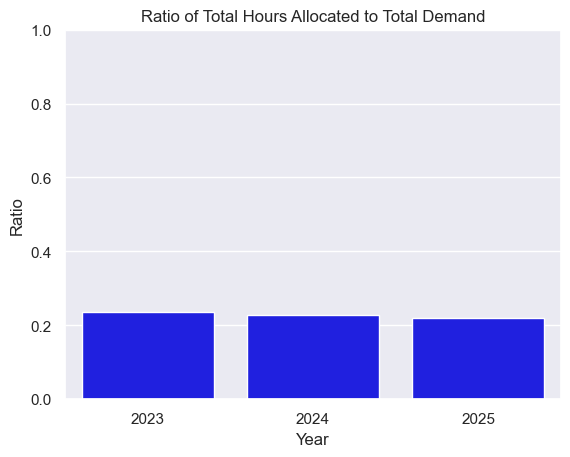

In [50]:
# Create a list of dictionaries to store the ratio values
ratio_data = []
for k in [2023, 2024, 2025]:
    total_demand = pred_demand[pred_demand["Year"] == k]['Demand'].sum()
    total_allocation = sum(xvar_f[(i,j,k)] for i in center for j in zone if isinstance(xvar_f[(i,j,k)], LpVariable))
    ratio = total_allocation.value() / total_demand
    ratio_data.append({'Year': k, 'Ratio': ratio})

# Create a DataFrame from the ratio data
ratio_df = pd.DataFrame(ratio_data)

# Create a barchart
sns.barplot(x='Year', y='Ratio', data=ratio_df, color='blue')
plt.title('Ratio of Total Hours Allocated to Total Demand')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.ylim((0, 1))
plt.show()

In [51]:
# other things...

In [52]:
for i in center:
    print("Average distance for "+str(i) + " to other zones is: "+ str(distances[distances['Center']==i]['Distance'].mean()))

Average distance for Center A to other zones is: 16.254285714285714
Average distance for Center B to other zones is: 22.712857142857143
Average distance for Center C to other zones is: 21.204285714285714
Average distance for Center D to other zones is: 21.69142857142857
Average distance for Center E to other zones is: 15.525714285714287
Average distance for Center F to other zones is: 20.21142857142857
